# Method 6 - Best Ideas High Popularity

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter Popularity

best_ideas['port_tilt_pct'] = best_ideas.groupby('datadate')['adj_target'].rank(pct=True)

popularity = best_ideas.groupby(['datadate', 'fsym_id'])['port_tilt_pct'].sum().reset_index()
popularity['median_port_tilt_pct'] = popularity.groupby('datadate')['port_tilt_pct'].transform('median')
popularity = popularity[popularity['port_tilt_pct'] > popularity['median_port_tilt_pct']]

best_ideas = best_ideas.merge(popularity[['datadate', 'fsym_id', 'median_port_tilt_pct']])

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

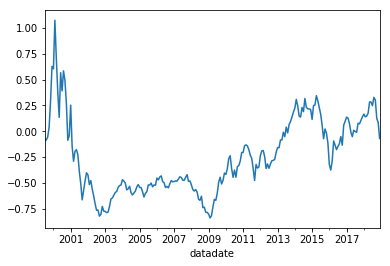

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.628518
2000-12-31   -0.411562
2001-12-31   -0.375657
2002-12-31   -0.620161
2003-12-31    1.108043
2004-12-31    0.011819
2005-12-31   -0.013912
2006-12-31    0.069824
2007-12-31    0.015135
2008-12-31   -0.585327
2009-12-31    1.768039
2010-12-31    0.334091
2011-12-31   -0.174484
2012-12-31    0.214727
2013-12-31    0.487612
2014-12-31    0.021034
2015-12-31   -0.267812
2016-12-31    0.237594
2017-12-31    0.038225
2018-12-31   -0.183287
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     226.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.68e-78
Time:                        14:04:11   Log-Likelihood:                 345.14
No. Observations:                 234   AIC:                            -680.3
Df Residuals:                     229   BIC:                            -663.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.240      0.216      -0.003       0.012
mktrf          1.4175      0.104     13.582      0.000       1.212       1.623
me             0.7516      0.121      6.191      0.000       0.512       0.991
ia            -0.2782      0.185     -1.508      0.133      -0.642       0.085
roe           -1.5427      0.158     -9.767      0.000      -1.854      -1.232
==============================================================================
Omnibus:                      148.142   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.987
Skew:                           2.195   Prob(JB):                         0.00
Kurtosis:                      16.919   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     141.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-60
Time:                        14:04:11   Log-Likelihood:                 345.14
No. Observations:                 234   AIC:                            -680.3
Df Residuals:                     229   BIC:                            -663.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.234      0.217      -0.003       0.012
mktrf          1.4175      0.202      7.028      0.000       1.022       1.813
me             0.7516      0.150      5.023      0.000       0.458       1.045
ia            -0.2782      0.237     -1.172      0.241      -0.744       0.187
roe           -1.5427      0.229     -6.727      0.000      -1.992      -1.093
==============================================================================
Omnibus:                      148.142   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.987
Skew:                           2.195   Prob(JB):                         0.00
Kurtosis:                      16.919   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     177.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.36e-69
Time:                        14:04:11   Log-Likelihood:                 345.14
No. Observations:                 234   AIC:                            -680.3
Df Residuals:                     229   BIC:                            -663.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.147      0.251      -0.003       0.013
mktrf          1.4175      0.204      6.949      0.000       1.018       1.817
me             0.7516      0.156      4.812      0.000       0.445       1.058
ia            -0.2782      0.240     -1.159      0.246      -0.749       0.192
roe           -1.5427      0.245     -6.298      0.000      -2.023      -1.063
==============================================================================
Omnibus:                      148.142   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.987
Skew:                           2.195   Prob(JB):                         0.00
Kurtosis:                      16.919   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     167.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.14e-74
Time:                        14:04:12   Log-Likelihood:                 338.35
No. Observations:                 234   AIC:                            -664.7
Df Residuals:                     228   BIC:                            -644.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.004      0.916      0.361      -0.004       0.012
mktrf          1.5766      0.108     14.613      0.000       1.364       1.789
smb            0.7925      0.142      5.567      0.000       0.512       1.073
hml            0.0643      0.168      0.383      0.702      -0.266       0.395
rmw           -1.4155      0.190     -7.458      0.000      -1.790      -1.042
cma           -0.0585      0.241     -0.242      0.809      -0.534       0.417
==============================================================================
Omnibus:                      135.785   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.326
Skew:                           2.160   Prob(JB):                    8.74e-244
Kurtosis:                      12.805   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     123.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.27e-63
Time:                        14:04:12   Log-Likelihood:                 338.35
No. Observations:                 234   AIC:                            -664.7
Df Residuals:                     228   BIC:                            -644.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.004      0.916      0.360      -0.004       0.011
mktrf          1.5766      0.136     11.596      0.000       1.310       1.843
smb            0.7925      0.149      5.307      0.000       0.500       1.085
hml            0.0643      0.279      0.230      0.818      -0.482       0.611
rmw           -1.4155      0.253     -5.602      0.000      -1.911      -0.920
cma           -0.0585      0.324     -0.181      0.857      -0.694       0.577
==============================================================================
Omnibus:                      135.785   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.326
Skew:                           2.160   Prob(JB):                    8.74e-244
Kurtosis:                      12.805   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     134.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.00e-66
Time:                        14:04:12   Log-Likelihood:                 338.35
No. Observations:                 234   AIC:                            -664.7
Df Residuals:                     228   BIC:                            -644.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.004      0.842      0.400      -0.005       0.012
mktrf          1.5766      0.125     12.591      0.000       1.331       1.822
smb            0.7925      0.146      5.433      0.000       0.507       1.078
hml            0.0643      0.229      0.281      0.779      -0.384       0.512
rmw           -1.4155      0.266     -5.316      0.000      -1.937      -0.894
cma           -0.0585      0.290     -0.202      0.840      -0.626       0.509
==============================================================================
Omnibus:                      135.785   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.326
Skew:                           2.160   Prob(JB):                    8.74e-244
Kurtosis:                      12.805   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     202.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.51e-74
Time:                        14:04:12   Log-Likelihood:                 334.97
No. Observations:                 234   AIC:                            -659.9
Df Residuals:                     229   BIC:                            -642.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.004     -0.214      0.831      -0.009       0.007
mktrf          1.6897      0.100     16.836      0.000       1.492       1.887
smb            1.4528      0.125     11.597      0.000       1.206       1.700
hml           -0.3093      0.124     -2.485      0.014      -0.555      -0.064
umd           -0.5234      0.082     -6.410      0.000      -0.684      -0.363
==============================================================================
Omnibus:                      122.703   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.962
Skew:                           1.853   Prob(JB):                    2.31e-239
Kurtosis:                      12.949   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     93.33
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.88e-47
Time:                        14:04:12   Log-Likelihood:                 334.97
No. Observations:                 234   AIC:                            -659.9
Df Residuals:                     229   BIC:                            -642.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.004     -0.232      0.817      -0.008       0.006
mktrf          1.6897      0.163     10.392      0.000       1.371       2.008
smb            1.4528      0.131     11.111      0.000       1.197       1.709
hml           -0.3093      0.194     -1.594      0.111      -0.690       0.071
umd           -0.5234      0.132     -3.967      0.000      -0.782      -0.265
==============================================================================
Omnibus:                      122.703   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.962
Skew:                           1.853   Prob(JB):                    2.31e-239
Kurtosis:                      12.949   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     105.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.92e-51
Time:                        14:04:12   Log-Likelihood:                 334.97
No. Observations:                 234   AIC:                            -659.9
Df Residuals:                     229   BIC:                            -642.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.004     -0.223      0.823      -0.008       0.006
mktrf          1.6897      0.163     10.393      0.000       1.371       2.008
smb            1.4528      0.120     12.074      0.000       1.217       1.689
hml           -0.3093      0.187     -1.654      0.098      -0.676       0.057
umd           -0.5234      0.138     -3.789      0.000      -0.794      -0.253
==============================================================================
Omnibus:                      122.703   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.962
Skew:                           1.853   Prob(JB):                    2.31e-239
Kurtosis:                      12.949   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     110.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-38
Time:                        14:04:12   Log-Likelihood:                 156.02
No. Observations:                 120   AIC:                            -302.0
Df Residuals:                     115   BIC:                            -288.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.006      1.379      0.171      -0.004       0.022
mktrf          1.3103      0.174      7.547      0.000       0.966       1.654
me             0.6817      0.171      3.976      0.000       0.342       1.021
ia            -0.6080      0.269     -2.264      0.025      -1.140      -0.076
roe           -1.5188      0.238     -6.391      0.000      -1.990      -1.048
==============================================================================
Omnibus:                       71.984   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              518.370
Skew:                           1.889   Prob(JB):                    2.74e-113
Kurtosis:                      12.455   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     137.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.41e-43
Time:                        14:04:12   Log-Likelihood:                 156.02
No. Observations:                 120   AIC:                            -302.0
Df Residuals:                     115   BIC:                            -288.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.006      1.533      0.125      -0.002       0.020
mktrf          1.3103      0.323      4.062      0.000       0.678       1.943
me             0.6817      0.210      3.250      0.001       0.271       1.093
ia            -0.6080      0.324     -1.874      0.061      -1.244       0.028
roe           -1.5188      0.335     -4.539      0.000      -2.175      -0.863
==============================================================================
Omnibus:                       71.984   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              518.370
Skew:                           1.889   Prob(JB):                    2.74e-113
Kurtosis:                      12.455   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     227.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-53
Time:                        14:04:12   Log-Likelihood:                 156.02
No. Observations:                 120   AIC:                            -302.0
Df Residuals:                     115   BIC:                            -288.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.006      1.519      0.129      -0.003       0.020
mktrf          1.3103      0.332      3.945      0.000       0.659       1.961
me             0.6817      0.217      3.140      0.002       0.256       1.107
ia            -0.6080      0.298     -2.039      0.041      -1.192      -0.024
roe           -1.5188      0.371     -4.089      0.000      -2.247      -0.791
==============================================================================
Omnibus:                       71.984   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              518.370
Skew:                           1.889   Prob(JB):                    2.74e-113
Kurtosis:                      12.455   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     87.84
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.89e-37
Time:                        14:04:12   Log-Likelihood:                 155.98
No. Observations:                 120   AIC:                            -300.0
Df Residuals:                     114   BIC:                            -283.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.007      1.364      0.175      -0.004       0.022
mktrf          1.6847      0.184      9.160      0.000       1.320       2.049
smb            0.8095      0.208      3.886      0.000       0.397       1.222
hml           -0.3763      0.255     -1.474      0.143      -0.882       0.129
rmw           -1.0445      0.301     -3.470      0.001      -1.641      -0.448
cma           -0.0301      0.330     -0.091      0.928      -0.683       0.623
==============================================================================
Omnibus:                       76.223   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              420.775
Skew:                           2.180   Prob(JB):                     4.26e-92
Kurtosis:                      11.071   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     96.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.22e-39
Time:                        14:04:12   Log-Likelihood:                 155.98
No. Observations:                 120   AIC:                            -300.0
Df Residuals:                     114   BIC:                            -283.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.005      1.752      0.080      -0.001       0.019
mktrf          1.6847      0.249      6.772      0.000       1.197       2.172
smb            0.8095      0.218      3.710      0.000       0.382       1.237
hml           -0.3763      0.218     -1.724      0.085      -0.804       0.052
rmw           -1.0445      0.357     -2.927      0.003      -1.744      -0.345
cma           -0.0301      0.360     -0.083      0.933      -0.736       0.676
==============================================================================
Omnibus:                       76.223   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              420.775
Skew:                           2.180   Prob(JB):                     4.26e-92
Kurtosis:                      11.071   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     153.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.06e-49
Time:                        14:04:12   Log-Likelihood:                 155.98
No. Observations:                 120   AIC:                            -300.0
Df Residuals:                     114   BIC:                            -283.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.005      1.697      0.090      -0.001       0.020
mktrf          1.6847      0.215      7.841      0.000       1.264       2.106
smb            0.8095      0.208      3.900      0.000       0.403       1.216
hml           -0.3763      0.173     -2.177      0.029      -0.715      -0.038
rmw           -1.0445      0.386     -2.708      0.007      -1.800      -0.288
cma           -0.0301      0.301     -0.100      0.920      -0.619       0.559
==============================================================================
Omnibus:                       76.223   Durbin-Watson:                   1.881
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              420.775
Skew:                           2.180   Prob(JB):                     4.26e-92
Kurtosis:                      11.071   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     121.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.37e-40
Time:                        14:04:12   Log-Likelihood:                 160.45
No. Observations:                 120   AIC:                            -310.9
Df Residuals:                     115   BIC:                            -297.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.006      0.729      0.467      -0.008       0.016
mktrf          1.7240      0.147     11.696      0.000       1.432       2.016
smb            1.3752      0.168      8.195      0.000       1.043       1.708
hml           -0.6494      0.168     -3.864      0.000      -0.982      -0.316
umd           -0.4806      0.104     -4.637      0.000      -0.686      -0.275
==============================================================================
Omnibus:                       71.842   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.036
Skew:                           1.890   Prob(JB):                    1.07e-111
Kurtosis:                      12.377   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     123.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.10e-40
Time:                        14:04:12   Log-Likelihood:                 160.45
No. Observations:                 120   AIC:                            -310.9
Df Residuals:                     115   BIC:                            -297.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.005      0.929      0.353      -0.005       0.014
mktrf          1.7240      0.236      7.307      0.000       1.262       2.186
smb            1.3752      0.139      9.873      0.000       1.102       1.648
hml           -0.6494      0.216     -3.006      0.003      -1.073      -0.226
umd           -0.4806      0.139     -3.454      0.001      -0.753      -0.208
==============================================================================
Omnibus:                       71.842   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.036
Skew:                           1.890   Prob(JB):                    1.07e-111
Kurtosis:                      12.377   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     250.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.40e-56
Time:                        14:04:12   Log-Likelihood:                 160.45
No. Observations:                 120   AIC:                            -310.9
Df Residuals:                     115   BIC:                            -297.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.005      0.952      0.341      -0.005       0.014
mktrf          1.7240      0.240      7.188      0.000       1.254       2.194
smb            1.3752      0.120     11.424      0.000       1.139       1.611
hml           -0.6494      0.187     -3.465      0.001      -1.017      -0.282
umd           -0.4806      0.153     -3.137      0.002      -0.781      -0.180
==============================================================================
Omnibus:                       71.842   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              511.036
Skew:                           1.890   Prob(JB):                    1.07e-111
Kurtosis:                      12.377   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     135.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.67e-41
Time:                        14:04:12   Log-Likelihood:                 209.44
No. Observations:                 114   AIC:                            -408.9
Df Residuals:                     109   BIC:                            -395.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.004      0.134      0.894      -0.007       0.008
mktrf          1.5252      0.116     13.164      0.000       1.296       1.755
me             0.8137      0.179      4.549      0.000       0.459       1.168
ia             0.3408      0.248      1.373      0.172      -0.151       0.833
roe           -1.6658      0.218     -7.640      0.000      -2.098      -1.234
==============================================================================
Omnibus:                       24.490   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.838
Skew:                           0.854   Prob(JB):                     9.13e-12
Kurtosis:                       5.790   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     113.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.28e-38
Time:                        14:04:12   Log-Likelihood:                 209.44
No. Observations:                 114   AIC:                            -408.9
Df Residuals:                     109   BIC:                            -395.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.176      0.860      -0.005       0.006
mktrf          1.5252      0.140     10.905      0.000       1.251       1.799
me             0.8137      0.235      3.458      0.001       0.352       1.275
ia             0.3408      0.265      1.287      0.198      -0.178       0.860
roe           -1.6658      0.354     -4.700      0.000      -2.361      -0.971
==============================================================================
Omnibus:                       24.490   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.838
Skew:                           0.854   Prob(JB):                     9.13e-12
Kurtosis:                       5.790   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     127.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.56e-40
Time:                        14:04:12   Log-Likelihood:                 209.44
No. Observations:                 114   AIC:                            -408.9
Df Residuals:                     109   BIC:                            -395.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.003      0.194      0.846      -0.005       0.006
mktrf          1.5252      0.130     11.710      0.000       1.270       1.781
me             0.8137      0.274      2.967      0.003       0.276       1.351
ia             0.3408      0.284      1.202      0.230      -0.215       0.897
roe           -1.6658      0.361     -4.616      0.000      -2.373      -0.959
==============================================================================
Omnibus:                       24.490   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.838
Skew:                           0.854   Prob(JB):                     9.13e-12
Kurtosis:                       5.790   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     97.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.04e-38
Time:                        14:04:12   Log-Likelihood:                 205.07
No. Observations:                 114   AIC:                            -398.1
Df Residuals:                     108   BIC:                            -381.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.004     -0.464      0.644      -0.010       0.006
mktrf          1.5707      0.115     13.616      0.000       1.342       1.799
smb            0.7444      0.187      3.975      0.000       0.373       1.116
hml            0.7303      0.239      3.058      0.003       0.257       1.204
rmw           -1.5330      0.292     -5.242      0.000      -2.113      -0.953
cma           -0.0935      0.371     -0.252      0.802      -0.829       0.642
==============================================================================
Omnibus:                       22.497   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.368
Skew:                           0.685   Prob(JB):                     2.12e-13
Kurtosis:                       6.227   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     113.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.59e-41
Time:                        14:04:12   Log-Likelihood:                 205.07
No. Observations:                 114   AIC:                            -398.1
Df Residuals:                     108   BIC:                            -381.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.004     -0.447      0.655      -0.010       0.006
mktrf          1.5707      0.104     15.157      0.000       1.368       1.774
smb            0.7444      0.207      3.596      0.000       0.339       1.150
hml            0.7303      0.217      3.361      0.001       0.304       1.156
rmw           -1.5330      0.368     -4.170      0.000      -2.254      -0.812
cma           -0.0935      0.308     -0.304      0.761      -0.696       0.509
==============================================================================
Omnibus:                       22.497   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.368
Skew:                           0.685   Prob(JB):                     2.12e-13
Kurtosis:                       6.227   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     127.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.23e-43
Time:                        14:04:12   Log-Likelihood:                 205.07
No. Observations:                 114   AIC:                            -398.1
Df Residuals:                     108   BIC:                            -381.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.004     -0.465      0.642      -0.010       0.006
mktrf          1.5707      0.107     14.664      0.000       1.361       1.781
smb            0.7444      0.230      3.236      0.001       0.294       1.195
hml            0.7303      0.188      3.878      0.000       0.361       1.099
rmw           -1.5330      0.340     -4.510      0.000      -2.199      -0.867
cma           -0.0935      0.322     -0.291      0.771      -0.724       0.537
==============================================================================
Omnibus:                       22.497   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.368
Skew:                           0.685   Prob(JB):                     2.12e-13
Kurtosis:                       6.227   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     102.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.92e-36
Time:                        14:04:12   Log-Likelihood:                 196.52
No. Observations:                 114   AIC:                            -383.0
Df Residuals:                     109   BIC:                            -369.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.004     -0.757      0.450      -0.012       0.005
mktrf          1.6251      0.123     13.214      0.000       1.381       1.869
smb            1.1023      0.192      5.748      0.000       0.722       1.482
hml            0.7005      0.197      3.547      0.001       0.309       1.092
umd           -0.4793      0.149     -3.217      0.002      -0.775      -0.184
==============================================================================
Omnibus:                       28.363   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.908
Skew:                           0.816   Prob(JB):                     4.94e-20
Kurtosis:                       7.006   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     145.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.56e-43
Time:                        14:04:12   Log-Likelihood:                 196.52
No. Observations:                 114   AIC:                            -383.0
Df Residuals:                     109   BIC:                            -369.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.004     -0.854      0.393      -0.011       0.004
mktrf          1.6251      0.118     13.830      0.000       1.395       1.855
smb            1.1023      0.202      5.454      0.000       0.706       1.498
hml            0.7005      0.227      3.085      0.002       0.255       1.146
umd           -0.4793      0.135     -3.555      0.000      -0.743      -0.215
==============================================================================
Omnibus:                       28.363   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.908
Skew:                           0.816   Prob(JB):                     4.94e-20
Kurtosis:                       7.006   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     200.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-49
Time:                        14:04:12   Log-Likelihood:                 196.52
No. Observations:                 114   AIC:                            -383.0
Df Residuals:                     109   BIC:                            -369.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.004     -0.877      0.380      -0.011       0.004
mktrf          1.6251      0.118     13.794      0.000       1.394       1.856
smb            1.1023      0.188      5.878      0.000       0.735       1.470
hml            0.7005      0.227      3.085      0.002       0.255       1.146
umd           -0.4793      0.126     -3.795      0.000      -0.727      -0.232
==============================================================================
Omnibus:                       28.363   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.908
Skew:                           0.816   Prob(JB):                     4.94e-20
Kurtosis:                       7.006   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""